#### **Library**

In [1]:
from google.colab import drive

# Mount Google-Drive Directory
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [22]:
!pip install -q contractions kagglehub

In [58]:
# general imports
import os
import re
import string
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import contractions
from PIL import Image
from collections import Counter
from matplotlib import pyplot as plt
from IPython.display import HTML, display
from sklearn.utils import shuffle
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings('ignore')


# spacy
import spacy

# Gensim
from gensim.models import Word2Vec, FastText, KeyedVectors
import gensim.parsing.preprocessing as gps
from gensim import utils


# NLTK
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from pathlib import Path
from google.colab import userdata
import kagglehub
from sklearn.utils import shuffle

In [24]:
FOLDER_PATH = Path(f"{userdata.get('FOLDER_PATH')}/SentXAI-Covid19")
%cd $FOLDER_PATH
# predictive-electric-vehicle

/content/gdrive/MyDrive/AI Models/SupervisedLearning/SentXAI-Covid19


#### **Dataset**

In [30]:
# Load data from kaggle
def pandas_df(path: str, file_name: str) -> pd.DataFrame:

    path = os.path.join(path, f"{file_name}")

    return pd.read_csv(path, encoding="latin1")

In [82]:
# https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification/data
PATH = kagglehub.dataset_download("datatattle/covid-19-nlp-text-classification")
pd.set_option("display.max_colwidth", 200)

# Load datasets
train_df = pandas_df(PATH, "Corona_NLP_train.csv")
test_df = pandas_df(PATH, "Corona_NLP_test.csv")

df = (
    pd.concat([train_df, test_df], axis=0)
    .rename(columns=str.lower)
    [["originaltweet", "sentiment"]]
    .rename(columns={"originaltweet": "tweet"})
)
df = shuffle(df, random_state=43).reset_index(drop=True)
df.head()

,tweet,sentiment
0,"Coronavirus Latest:Drivers In #NJ, Around Country Still Seeing Gas Prices Drop Amid COVID- - Mar 21 @ 10:28 AM ET https://t.co/zxLZVHbyVW",Negative
1,ItÂs a difficult time for everyone at the moment but PLEASE do not stockpile and panic buy.. If you just buy what you need as normal there will be plenty of food and essential supplies for everyo...,Extremely Positive
2,"Or buy gift certificates for others who may be in self-quarantine. A little online shopping will pass the time and keep local businesses alive. Plus, more books! #coronavirus #books",Extremely Positive
3,"""LA rental prices fall for the first time in a decade.""\r\r\n#coronavirus #realestate #Investment \r\r\n\r\r\nhttps://t.co/1HniyhooOA",Neutral
4,Covid-19 coronavirus: Rotorua shoppers wear beekeeping suits to supermarket ????? https://t.co/QfPj5KzN1p,Neutral


In [89]:
dataframe = df.copy()

# Assign Labels
sentiment_labels = ['neg(-)', 'ext-pos(+)', 'neu(0)', 'ext-neg(-)', 'pos(+)']
map_labels = {k: c for c, k in zip(sentiment_labels, df["sentiment"].unique())}
dataframe["sentiment"] = df["sentiment"].map(map_labels)

#### **Data Overview**

In [90]:
# Data dimension
print("Dimension: ", dataframe.shape)

Dimension:  (44955, 2)


In [91]:
# Data Information
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      44955 non-null  object
 1   sentiment  44955 non-null  object
dtypes: object(2)
memory usage: 702.5+ KB


In [92]:
# Missing and Duplicates
print("\nNumber of missing values")
print("-" * 30)
print(dataframe.isna().sum())

print("\nNumber of duplicated values")
print("-" * 30)
print(dataframe.duplicated().sum())


Number of missing values
------------------------------
tweet        0
sentiment    0
dtype: int64

Number of duplicated values
------------------------------
0


In [106]:
sentiment_df = dataframe["sentiment"].value_counts().reset_index(name="size")

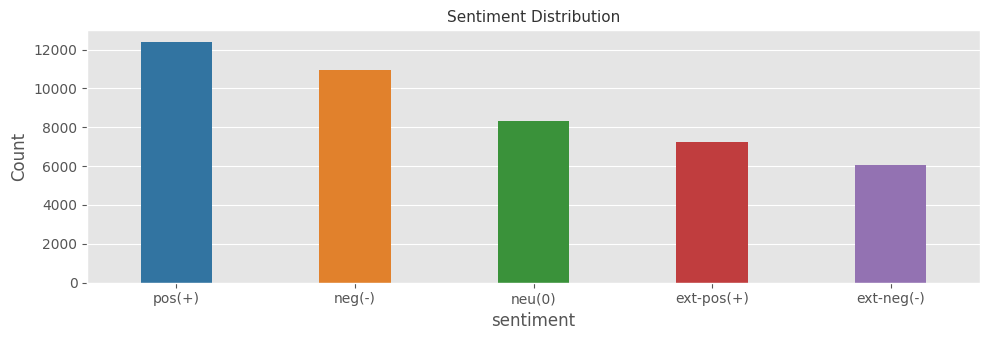

In [120]:
# Sentiment Plot Distribution
_, ax = plt.subplots(1, 1, figsize=(10, 3.5))
plt.style.use("ggplot")

sns.barplot(sentiment_df, x="sentiment", y="size", hue="sentiment", palette="tab10", gap=0.5, ax=ax)
ax.set_title("Sentiment Distribution", fontsize=11, alpha=0.8)
ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

#### **Data Processing & Cleaning**

In [ ]:
import nltk
from sklearn.feature_extraction import text

nltk.download("popular")
nltk.download('punkt_tab')

In [141]:
# Define Stopwords
words = np.unique(text.ENGLISH_STOP_WORDS.union(stopwords.words('english')))
stopword_list = [c for c in words]

# Define spacy lemmatization
spacy_lemma = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

In [142]:
# text preprocessing method
def text_processor(text):
    # case-fold each character
    text = text.strip().lower()

    # remove links & mentions
    text = re.sub(r'https:\W.+','', text)
    text = re.sub(r'@\w+|&\w+', '', text)

    # remove punctuations & emojis
    text = re.sub(r'[%s]'%re.escape(string.punctuation), ' ', text)

    # remove non-alphanumeric characters
    text = re.sub(r'\W+', ' ', text)

    # remove digits
    text = re.sub(r'\d+', ' ', text)
    # remove all stopwords
    text = ' '.join([word for word in word_tokenize(text) if word not in stopword_list])

    # lemmatize words into root-form & discard words with two characters
    text  = ' '.join([word.lemma_ for word in spacy_lemma(text) if len(word)>=2])

    return text


In [143]:
# Data Type Correction
dataframe = dataframe.astype(str)

# apply text preprocessing method
dataframe['text'] = dataframe.tweet.map(text_processor)

# calculate text length
dataframe['length'] = dataframe.text.map(len)

# consider dataframe points with length above
dataframe = dataframe[dataframe.length >= 5].drop(columns=['length'])

# remove both N/A and duplicated dataframe points
sort_columns = ["tweet", "text", "sentiment"]

dataframe = (
    dataframe[sort_columns]
    .dropna().drop_duplicates()
)

dataframe.head()

,tweet,text,sentiment
0,"Coronavirus Latest:Drivers In #NJ, Around Country Still Seeing Gas Prices Drop Amid COVID- - Mar 21 @ 10:28 AM ET https://t.co/zxLZVHbyVW",coronavirus late driver in nj around country still see gas price drop amid covid mar be et,neg(-)
1,ItÂs a difficult time for everyone at the moment but PLEASE do not stockpile and panic buy.. If you just buy what you need as normal there will be plenty of food and essential supplies for everyo...,itâ difficult time for everyone at the moment but please do not stockpile and panic buy if you just buy what you need as normal there will be plenty of food and essential supply for everyone think...,ext-pos(+)
2,"Or buy gift certificates for others who may be in self-quarantine. A little online shopping will pass the time and keep local businesses alive. Plus, more books! #coronavirus #books",or buy gift certificate for other who may be in self quarantine little online shopping will pass the time and keep local business alive plus more book coronavirus book,ext-pos(+)
3,"""LA rental prices fall for the first time in a decade.""\r\r\n#coronavirus #realestate #Investment \r\r\n\r\r\nhttps://t.co/1HniyhooOA",la rental price fall for the first time in decade coronavirus realestate investment,neu(0)
4,Covid-19 coronavirus: Rotorua shoppers wear beekeeping suits to supermarket ????? https://t.co/QfPj5KzN1p,covid coronavirus rotorua shopper wear beekeepe suit to supermarket,neu(0)


#### **Save Processed Data**

In [144]:
%%bash
# Create processed folder only if it does not exist in the folder tree.
FILE_DIR="processed"

if [[ ! -d "$FILE_DIR" ]]; then
    echo "Create '$FILE_DIR' folder ..."
    mkdir -p processed
else
    echo "Folder '$FILE_DIR' already exists."
fi

Create 'processed' folder ...


In [145]:
# Naming file output
FILE_NAME = "corona_tweets_covid19.csv"
FILE_OUTPUT = os.path.join("processed", FILE_NAME)

# Log existing files into file_log.txt
!find . -maxdepth 2 -type f > file_log.txt

# Load existing files into a pyton list
with open("file_log.txt", "r") as f:
    list_files = [file.split("/")[-1].rstrip() for file in f.readlines()]
    print(list_files)

['notebook_cleaning.ipynb', 'description', 'packed-refs', 'HEAD', 'config', 'index', '.gitignore', 'README.md', 'file_log.txt']


In [146]:
if FILE_NAME not in list_files:
    print("Saving processed dataset ...")
    dataframe.to_csv(FILE_OUTPUT, index=False)
else:
    print(f"File '{FILE_OUTPUT}' already created.")

Saving processed dataset ...
